In [66]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import math
from huggingface_hub.repocard_data import model_index_to_eval_results


def plot_images(images, nrows=1, ncols=5, cmap='gray', figsize=(20, 10), filename=None):
    """
    Plot a list of images using matplotlib subplots.

    Args:
        images (list or np.ndarray): List or array of images to plot.
        nrows (int): Number of rows in the subplot grid.
        ncols (int): Number of columns in the subplot grid.
        cmap (str): Color map for the images (e.g., 'gray', 'viridis').
        figsize (tuple): Tuple specifying the overall figure size (width, height).
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Iterate through all the subplots
    for i, ax in enumerate(axes):
        if i < len(images):  # Plot if there are images left
            ax.imshow(images[i], cmap=cmap)
            ax.axis('off')  # Turn off axes
        else:  # Turn off any extra axes (used when images < nrows*ncols)
            ax.axis('off')

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


def show_reconstructions_code(model, images, shape, n_images=5, **kwargs):
    code = model.layers[0].predict(images[:n_images])
    code_images = code.reshape([n_images] + list(shape))
    reconstructed_images = model.layers[1].predict(code)
    # all_images = np.append(images, reconstructed_images, axis=0)
    all_images = [x for x in images[:n_images]]
    all_images.extend(code_images)
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=3, **kwargs)


def show_code_reconstructions(decoder, codes, n_images=5, shape=None):
    code_shape = (1, codes.shape[1])
    reconstructions = decoder.predict(codes[:n_images])
    reconstructed_images = reconstructions if shape is None else reconstructions.reshape([n_images] + list(shape))
    all_images = [x.reshape(code_shape) for x in codes]
    all_images.extend(reconstructed_images)
    plot_images(all_images, nrows=2)


def plot_reconstructions(model, images, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

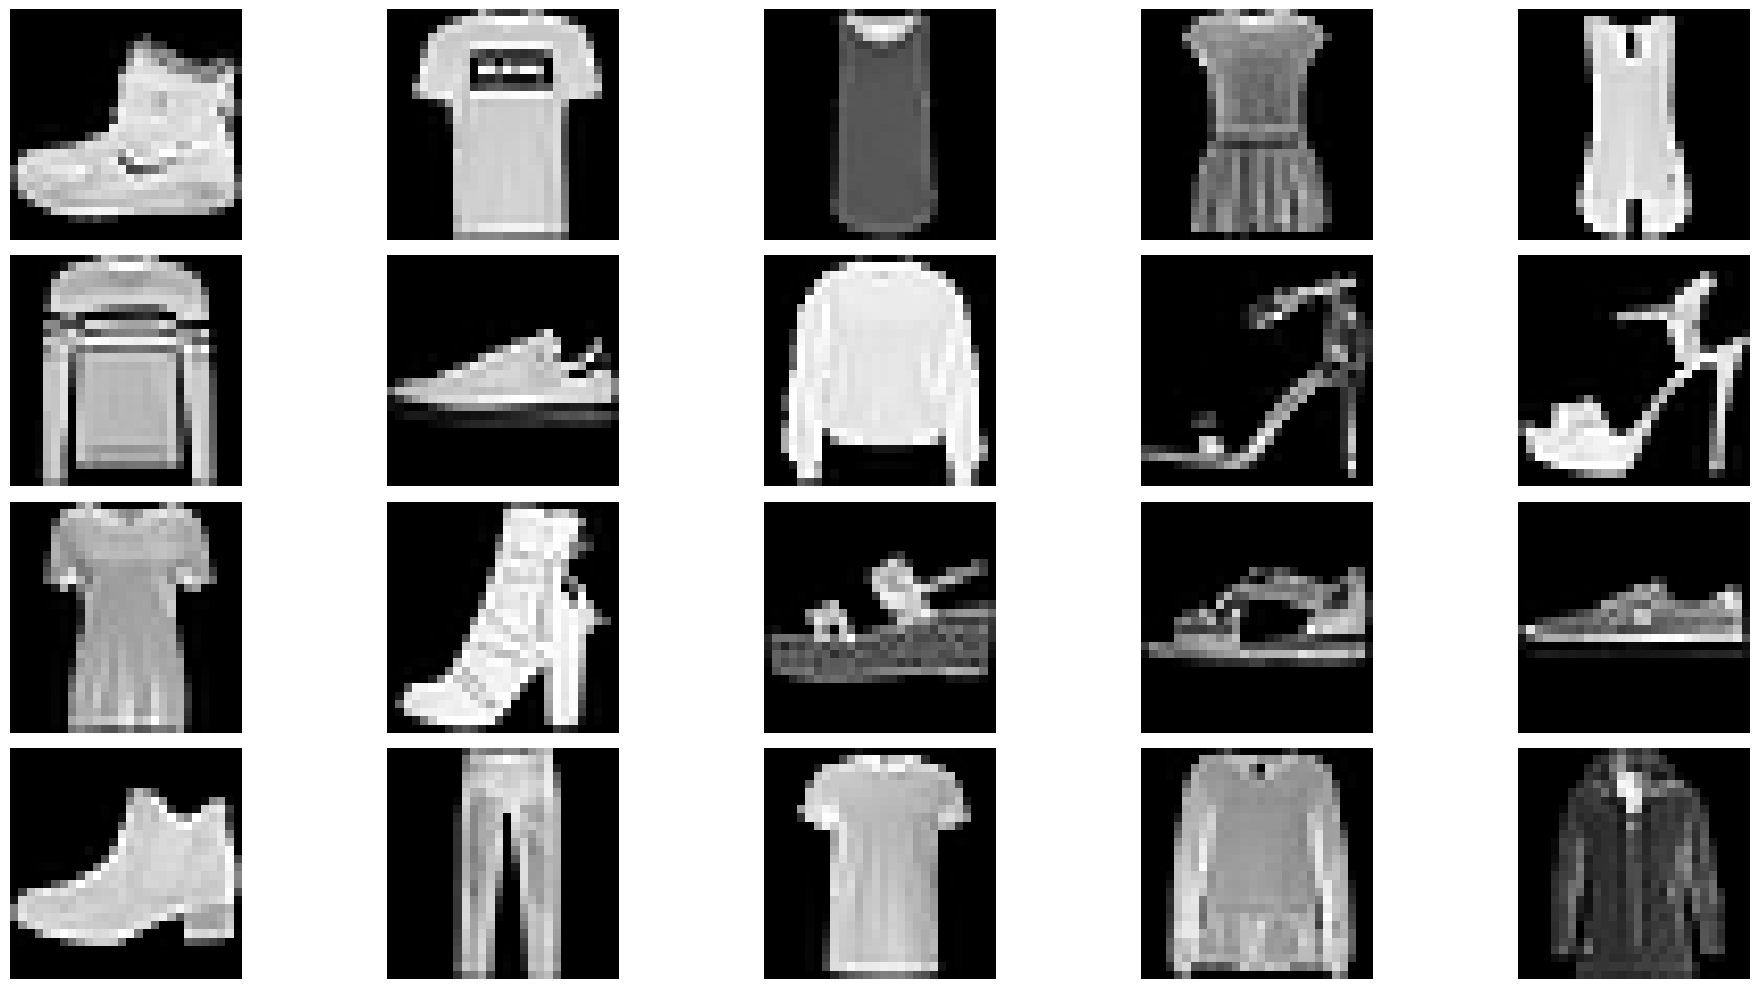

In [67]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

plot_images(X_train[:20], 4, 5)

In [68]:
base_model = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(),
                keras.layers.Dense(10, activation="softmax", name="output"),
                ]
)
optimizer = keras.optimizers.Adam(learning_rate=0.02)
base_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)
base_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history = base_model.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=10
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7565 - loss: 0.9118 - val_accuracy: 0.8056 - val_loss: 0.8096
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8084 - loss: 0.7988 - val_accuracy: 0.7826 - val_loss: 1.0029
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8168 - loss: 0.8014 - val_accuracy: 0.8136 - val_loss: 0.8153
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8244 - loss: 0.7639 - val_accuracy: 0.8080 - val_loss: 0.8539
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8226 - loss: 0.8004 - val_accuracy: 0.8208 - val_loss: 0.8331
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8216 - loss: 0.7929 - val_accuracy: 0.8096 - val_loss: 0.9520
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8260 - loss: 0.7851 - val_accuracy: 0.8288 - val_loss: 0.7740
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8245 - loss: 0.7859 - 

In [70]:
model1 = keras.Sequential(
    [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(name="input_layer"),
                keras.layers.Dense(5, activation="relu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output"),
                ]
)

In [71]:
optimizer1 = keras.optimizers.Adam(learning_rate=0.02)
model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer1,
    metrics=["accuracy"]
)
model1.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 5)              │         3,925 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,985 (15.57 KB)

 Trainable params: 3,985 (15.57 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history1 = model1.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=10
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5173 - loss: 1.2125 - val_accuracy: 0.5940 - val_loss: 0.9403
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6089 - loss: 0.9340 - val_accuracy: 0.5998 - val_loss: 0.9420
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6138 - loss: 0.9185 - val_accuracy: 0.5586 - val_loss: 1.0913
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6149 - loss: 0.9189 - val_accuracy: 0.6070 - val_loss: 0.9011
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6210 - loss: 0.8947 - val_accuracy: 0.5728 - val_loss: 0.9791
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6171 - loss: 0.8937 - val_accuracy: 0.6248 - val_loss: 0.8894
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6199 - loss: 0.8913 - val_accuracy: 0.6214 - val_loss: 0.8783
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6192 - loss: 0.8955 - 

In [73]:
model2 = keras.Sequential(
        [
                keras.layers.Input(shape=[28, 28]),
                keras.layers.Flatten(name="input_layer"),
                keras.layers.Dense(64, activation="selu", name="hidden_layer"),
                keras.layers.Dense(10, activation="softmax", name="output"),
                ]
)
optimizer2 = keras.optimizers.Adam(learning_rate=0.02)
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer2,
    metrics=["accuracy"]
)
model2.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history2 = model2.fit(
    X_train, y_train, validation_data=(X_valid, y_valid),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7402 - loss: 0.8465 - val_accuracy: 0.8288 - val_loss: 0.5154
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8031 - loss: 0.6421 - val_accuracy: 0.7810 - val_loss: 0.7956
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8103 - loss: 0.6399 - val_accuracy: 0.8092 - val_loss: 0.6164
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8137 - loss: 0.6254 - val_accuracy: 0.7724 - val_loss: 0.7701
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8156 - loss: 0.6174 - val_accuracy: 0.8248 - val_loss: 0.6682
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8240 - loss: 0.5983 - val_accuracy: 0.8050 - val_loss: 0.7388
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8186 - loss: 0.6397 - val_accuracy: 0.8082 - val_loss: 0.6949
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8252 - loss: 0.5855 - 

In [75]:
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7943 - loss: 0.8775


[0.899344265460968, 0.7936000227928162]

## Autoencoder


In [113]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


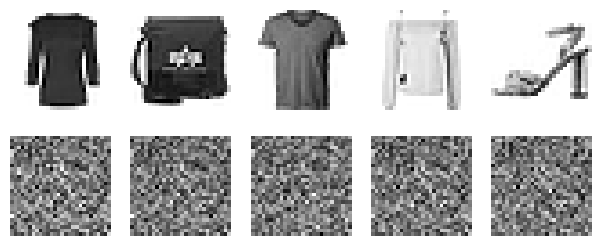

In [114]:

code_size = 9
stacked_encoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu")
        ]
    )
stacked_decoder = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
loss = "binary_crossentropy"
stacked_ae.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/10
430/430 - 3s - 7ms/step - loss: 0.4223 - rounded_accuracy: 0.8140 - val_loss: 0.3735 - val_rounded_accuracy: 0.8575
Epoch 2/10
430/430 - 1s - 3ms/step - loss: 0.3649 - rounded_accuracy: 0.8629 - val_loss: 0.3673 - val_rounded_accuracy: 0.8577
Epoch 3/10
430/430 - 1s - 3ms/step - loss: 0.3495 - rounded_accuracy: 0.8760 - val_loss: 0.3469 - val_rounded_accuracy: 0.8799
Epoch 4/10
430/430 - 1s - 2ms/step - loss: 0.3435 - rounded_accuracy: 0.8808 - val_loss: 0.3515 - val_rounded_accuracy: 0.8662
Epoch 5/10
430/430 - 1s - 3ms/step - loss: 0.3387 - rounded_accuracy: 0.8851 - val_loss: 0.3367 - val_rounded_accuracy: 0.8905
Epoch 6/10
430/430 - 1s - 3ms/step - loss: 0.3337 - rounded_accuracy: 0.8892 - val_loss: 0.3341 - val_rounded_accuracy: 0.8890
Epoch 7/10
430/430 - 1s - 3ms/step - loss: 0.3302 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8950
Epoch 8/10
430/430 - 1s - 3ms/step - loss: 0.3279 - rounded_accuracy: 0.8935 - val_loss: 0.3340 - val_rounded_a

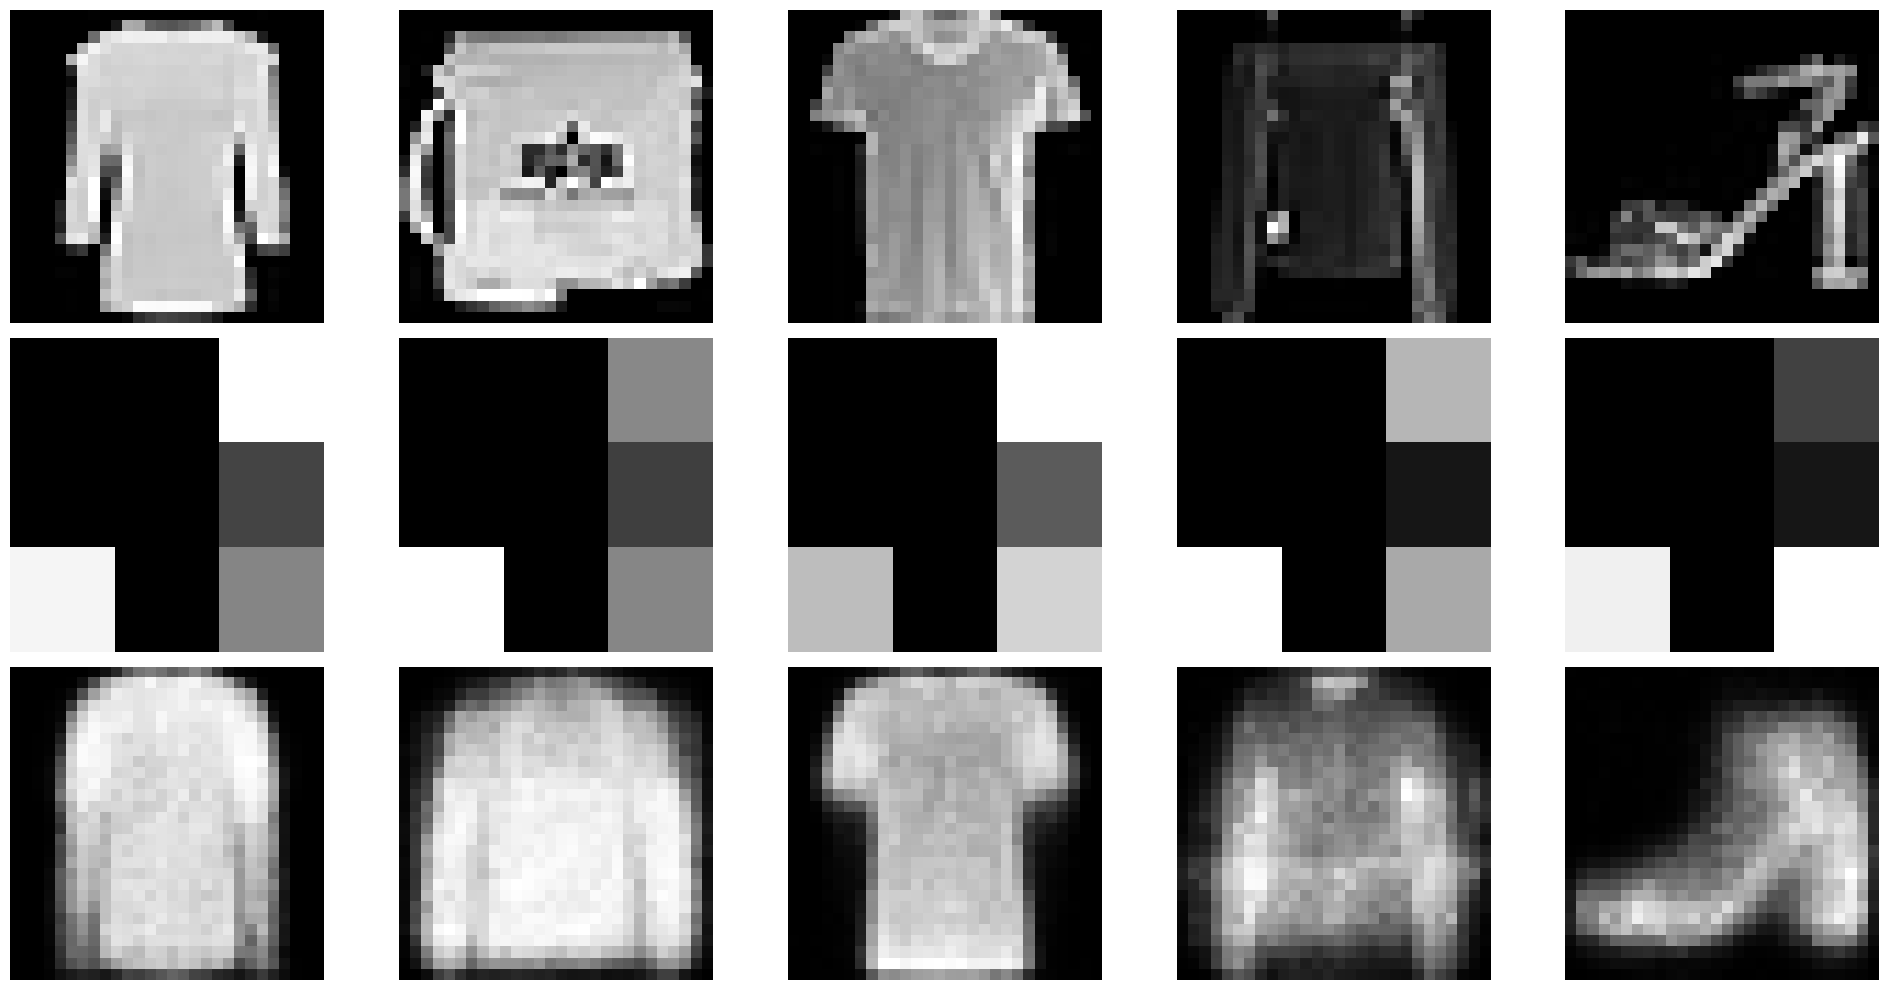

In [115]:
stacked_ae.fit(
    X_train, X_train, validation_data=(X_valid, X_valid),
    epochs=10, batch_size=128, verbose=2
)
show_reconstructions_code(stacked_ae, X_valid, shape=[3, 3], n_images=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


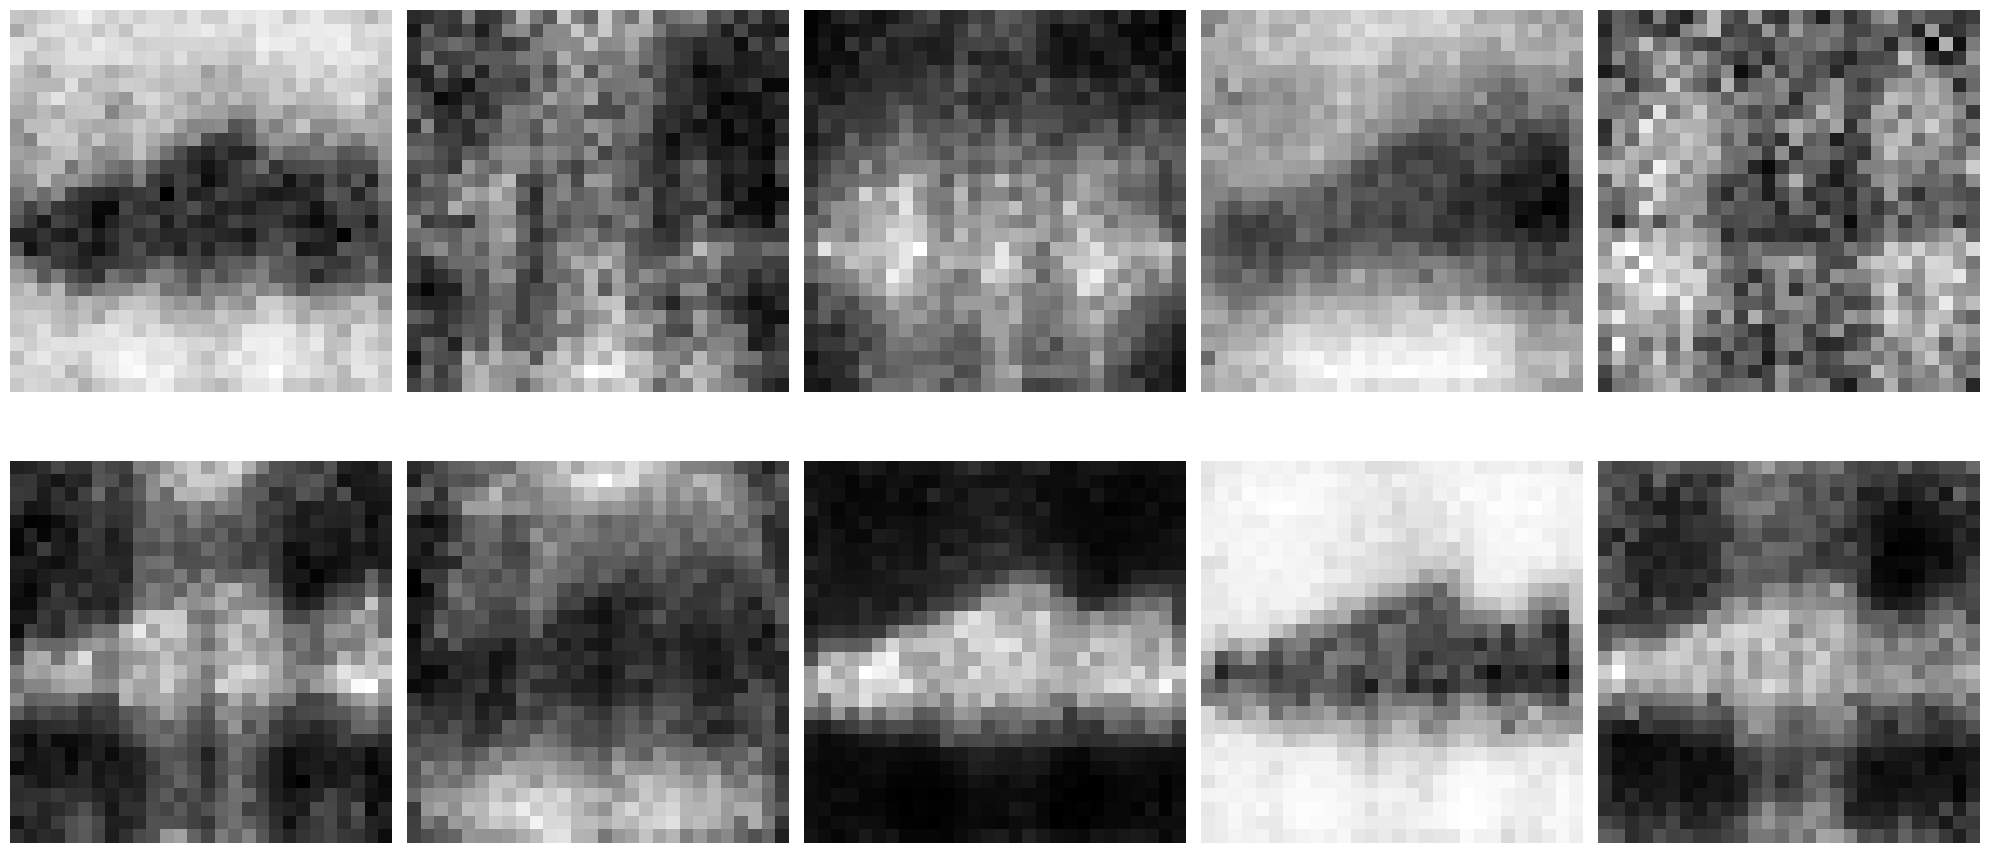

In [116]:
X_code = np.random.normal(size=(10, code_size))
images = stacked_decoder.predict(X_code)
plot_images(images, nrows=2, ncols=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


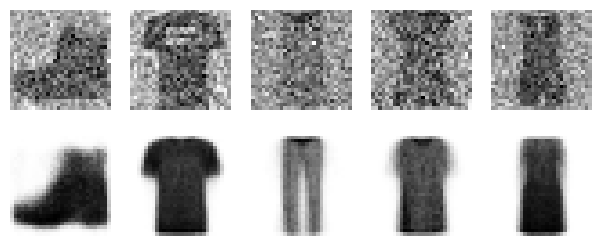

In [117]:
noise = keras.layers.GaussianNoise(0.3)
X_noise = noise(X_train, training=True).numpy()
plot_reconstructions(stacked_ae, images=X_noise[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


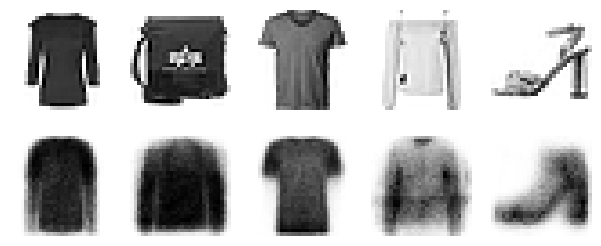

In [118]:
code_size = 64
stacked_encoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(),
        keras.layers.Dense(14 * 14, activation="selu"),
        keras.layers.Dense(code_size, activation="selu")
        ]
    )
stacked_decoder1 = keras.models.Sequential(
    [
        keras.layers.Input(shape=[code_size]),
        keras.layers.Dense(196, activation="selu"),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ]
)

stacked_ae1 = keras.models.Sequential([stacked_encoder1, stacked_decoder1])
loss = "binary_crossentropy"
stacked_ae1.compile(
    loss=loss, optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy]
)
plot_reconstructions(stacked_ae, images=X_valid)

Epoch 1/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.4382 - rounded_accuracy: 0.8012 - val_loss: 0.3290 - val_rounded_accuracy: 0.9017
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3222 - rounded_accuracy: 0.9012 - val_loss: 0.3168 - val_rounded_accuracy: 0.9087
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9094 - val_loss: 0.3099 - val_rounded_accuracy: 0.9119
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3077 - rounded_accuracy: 0.9139 - val_loss: 0.3045 - val_rounded_accuracy: 0.9196
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.3007 - val_rounded_accuracy: 0.9210
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2993 - rounded_accuracy: 0.9217 - val_loss: 0.2979 - val_rounded_accuracy: 0.9230
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2968 - rounded_accuracy: 0.9240 - val_loss: 0.2960 - val_rounded_accuracy:

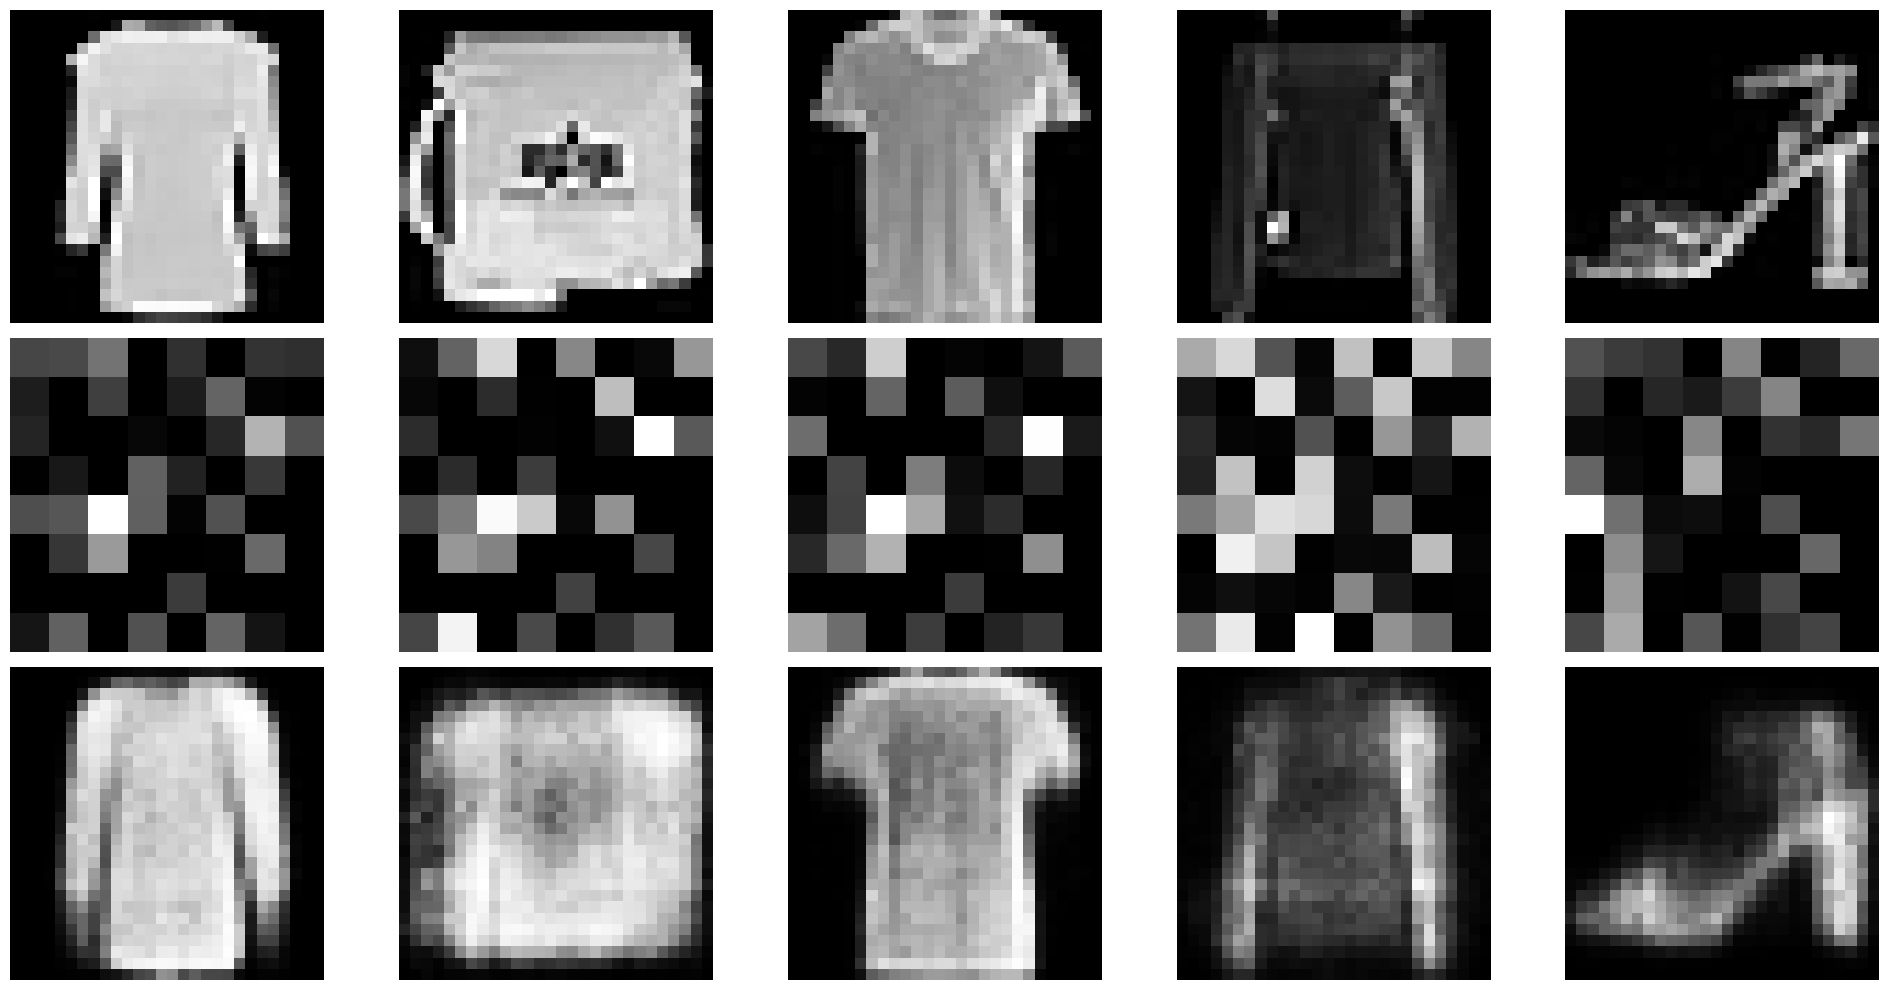

In [119]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0.002,
    patience=2,
    mode='auto',
    restore_best_weights=True,
    verbose=True
)
stacked_ae1.fit(
    X_train, X_train, validation_data=(X_valid, X_valid),
    epochs=20, batch_size=128,
    callbacks=[early_stopping]
)
show_reconstructions_code(stacked_ae1, X_valid, shape=[8, 8], n_images=5)

In [120]:
(mnist_images, mnist_labels) , (mnist_teimages_test, mnist_labels_test) = keras.datasets.mnist.load_data()
X_train_digits = tf.cast(mnist_images / 255, tf.float32)
y_train_digits = tf.cast(mnist_labels, tf.int64)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [129]:
ds = tf.data.Dataset.from_tensor_slices((X_train_digits, y_train_digits))
for x, y in ds.take(2):
    print(f"x.shape: {x.shape}, y.shape: {y.shape}")


x.shape: (28, 28), y.shape: ()
x.shape: (28, 28), y.shape: ()


In [130]:
ds_fashion = tf.data.Dataset.from_tensor_slices((X_train[:10_000], y_train[:10_000]))
ds_negative = ds_fashion.map(lambda x, y: (x, tf.cast(10, tf.int64)))
ds = ds.concatenate(ds_negative)
ds = ds.shuffle(1000).batch(128)

In [131]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=[28, 28]),
        keras.layers.Flatten(name="input_layer"),
        keras.layers.Dense(20, activation="relu", name="hidden_layer"),
        keras.layers.Dense(11, activation="softmax", name="output"),
    ]
)
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer (Dense)            │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 11)             │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,931 (62.23 KB)

 Trainable params: 15,931 (62.23 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
model.fit(ds, epochs=10)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7347 - loss: 0.9579
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8561 - loss: 0.4979
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9181 - loss: 0.2868
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9332 - loss: 0.2345
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9409 - loss: 0.2082
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9465 - loss: 0.1903
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9509 - loss: 0.1744
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9544 - loss: 0.1621
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9575 - loss: 0.1513
Epoch 10/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9589 - loss: 0.1437


In [133]:
model.predict(X_valid[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


array([[2.4110997e-19, 2.0385922e-26, 2.3768848e-16, 1.6274764e-14,
        3.8994577e-27, 1.6021256e-14, 3.6039758e-19, 5.0248857e-15,
        1.2470052e-23, 1.3622361e-23, 1.0000000e+00],
       [3.7394656e-38, 2.0289400e-41, 2.7878134e-29, 7.3632575e-29,
        8.1835830e-43, 7.9784211e-22, 4.7295387e-33, 4.0403426e-27,
        9.6773672e-42, 0.0000000e+00, 1.0000000e+00],
       [7.7654181e-27, 1.1074857e-31, 2.6364609e-21, 5.2601191e-20,
        7.1478467e-32, 2.0498297e-18, 4.3749150e-23, 1.2056184e-15,
        3.9840387e-33, 5.8372219e-31, 1.0000000e+00],
       [3.5744717e-05, 1.7320932e-06, 1.0349758e-04, 3.5014484e-04,
        2.5658537e-06, 1.4468393e-03, 1.1563801e-05, 4.6338790e-04,
        3.7810569e-06, 9.7818668e-07, 9.9757975e-01],
       [4.1929640e-11, 3.4340504e-12, 6.5748355e-07, 1.5187133e-10,
        2.3629731e-13, 3.0370390e-07, 2.9357029e-08, 9.3611986e-11,
        3.7088062e-11, 8.4705804e-16, 9.9999905e-01],
       [0.0000000e+00, 0.0000000e+00, 1.3556916e-3

In [134]:
model.predict(X_train_digits[10:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


array([[7.16427238e-08, 5.48948856e-06, 3.01398089e-08, 9.99961972e-01,
        1.70034167e-10, 1.82129418e-06, 2.80496210e-10, 1.31093465e-08,
        1.19005808e-05, 1.87462902e-05, 7.23781879e-09],
       [4.07839922e-04, 3.40548437e-03, 1.72298774e-02, 2.59905704e-04,
        8.44038266e-04, 9.68665123e-01, 2.01838033e-04, 3.62157403e-03,
        5.22428565e-03, 1.64136816e-06, 1.38345116e-04],
       [4.91522459e-13, 3.93426736e-10, 6.46575273e-08, 9.99999762e-01,
        1.68539474e-10, 2.68042721e-09, 4.95947379e-14, 2.28872254e-10,
        4.79053330e-09, 1.11940335e-09, 9.71984235e-08],
       [6.88695422e-07, 2.99838554e-08, 3.83243460e-04, 5.51446703e-07,
        5.24876057e-04, 3.95581083e-05, 9.96379077e-01, 7.68309178e-07,
        4.59968896e-06, 2.90052822e-06, 2.66382028e-03],
       [4.32767138e-07, 9.98154104e-01, 2.91099597e-04, 3.13916447e-04,
        2.22925974e-06, 1.87425630e-05, 5.15855027e-05, 5.16465923e-04,
        6.09831477e-04, 3.56877172e-05, 5.79608377e-